# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [56]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [57]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [58]:
import os

## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)

os.makedirs('./src', exist_ok=True) # Create the 'src' directory if it doesn't exist
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(52, 6)


,title,price,year,link,brand,age
0,mercedes suv,1000,NaN,https://charlottesville.craigslist.org/cto/d/k...,missing,NaN
1,2016 ford escape titanium 4x4,2000,2016.0,https://charlottesville.craigslist.org/cto/d/c...,ford,9.0
2,2006 honda accord 4dr ex-l,4300,2006.0,https://charlottesville.craigslist.org/cto/d/t...,honda,19.0
3,"rare 1977 plymouth volare wagon , 4 speed",9400,1977.0,https://charlottesville.craigslist.org/cto/d/s...,missing,48.0
4,97 dodge ram,4000,NaN,https://charlottesville.craigslist.org/cto/d/l...,dodge,NaN


With the data in and wrangled, we can now do some analysis:

count       52.000000
mean      8622.096154
std      11286.586315
min       1000.000000
25%       2500.000000
50%       5100.000000
75%       9025.000000
max      69500.000000
Name: price, dtype: float64


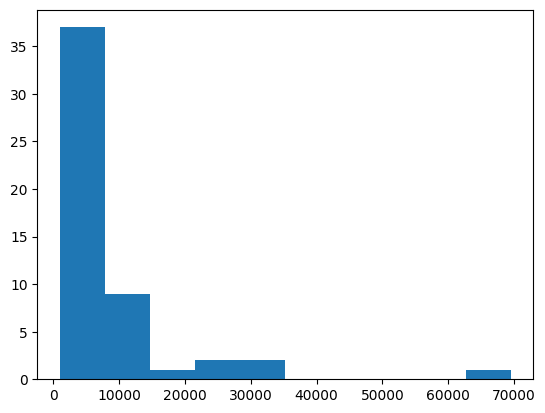

count    44.000000
mean     18.340909
std      13.571419
min       0.000000
25%      12.000000
50%      15.000000
75%      19.250000
max      75.000000
Name: age, dtype: float64


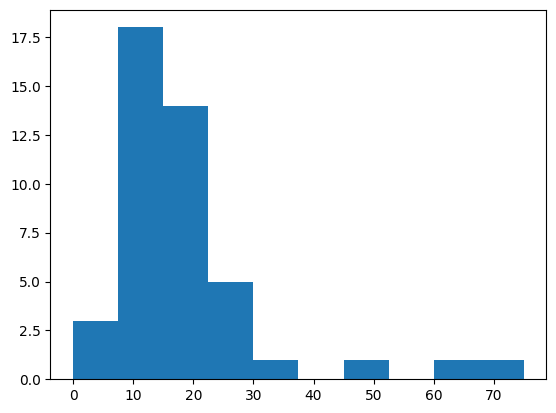

In [59]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [60]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
bmw          2.0   7500.000000   9192.388155   1000.0   4250.00   7500.0   
dodge        1.0   4000.000000           NaN   4000.0   4000.00   4000.0   
ford        10.0  13085.000000  20333.880457   1500.0   3700.00   5650.0   
gmc          1.0  26700.000000           NaN  26700.0  26700.00  26700.0   
honda        7.0   4742.857143   2614.610961   1200.0   3150.00   4300.0   
jeep         1.0   8500.000000           NaN   8500.0   8500.00   8500.0   
kia          1.0   1500.000000           NaN   1500.0   1500.00   1500.0   
lexus        1.0   2500.000000           NaN   2500.0   2500.00   2500.0   
mazda        2.0  15870.000000  19968.695501   1750.0   8810.00  15870.0   
missing     16.0   8115.562500   8764.053955   1000.0   2450.00   5850.0   
toyota       7.0   6560.714286   5037.398823   2000.0   3737.50   5000.0   
volkswagen   1.0   2600.000000           NaN   2600.0   2600.00   2600.0   
volvo        2.0   7992.500000   5243.196782   4285.0   6138.75   7992.5   

                               
                 75%      max  
brand                          
bmw         10750.00  14000.0  
dodge        4000.00   4000.0  
ford        12737.50  69500.0  
gmc         26700.00  26700.0  
honda        6250.00   8900.0  
jeep         8500.00   8500.0  
kia          1500.00   1500.0  
lexus        2500.00   2500.0  
mazda       22930.00  29990.0  
missing      8049.25  32000.0  
toyota       7225.00  17000.0  
volkswagen   2600.00   2600.0  
volvo        9846.25  11700.0

In [61]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
bmw          2.0  19.500000  10.606602  12.0  15.75  19.5  23.25  27.0
dodge        0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
ford        10.0  19.200000  20.263816   6.0   9.75  13.0  15.50  75.0
gmc          0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
honda        6.0  14.833333   3.970726  10.0  12.25  14.0  18.00  20.0
jeep         0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
kia          1.0  14.000000        NaN  14.0  14.00  14.0  14.00  14.0
lexus        1.0  24.000000        NaN  24.0  24.00  24.0  24.00  24.0
mazda        2.0   6.500000   9.192388   0.0   3.25   6.5   9.75  13.0
missing     13.0  23.000000  15.869257   4.0  14.00  18.0  24.00  62.0
toyota       6.0  14.666667   4.320494   8.0  12.00  16.0  17.75  19.0
volkswagen   1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
volvo        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0

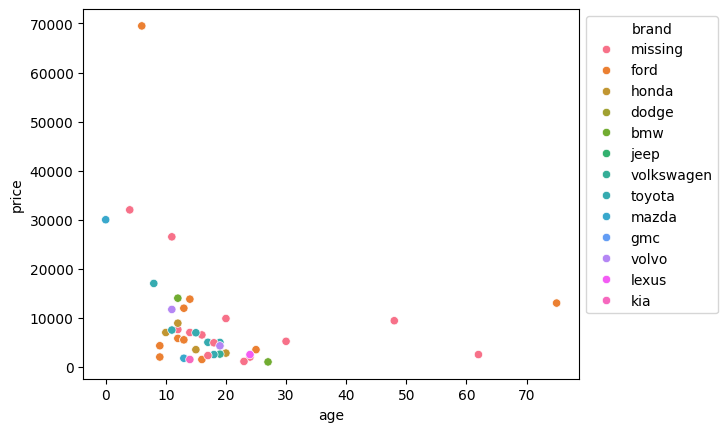

In [62]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   0.914479 -0.202559
log_age    -0.202559  0.291514
           log_price  log_age
log_price    1.00000 -0.41315
log_age     -0.41315  1.00000


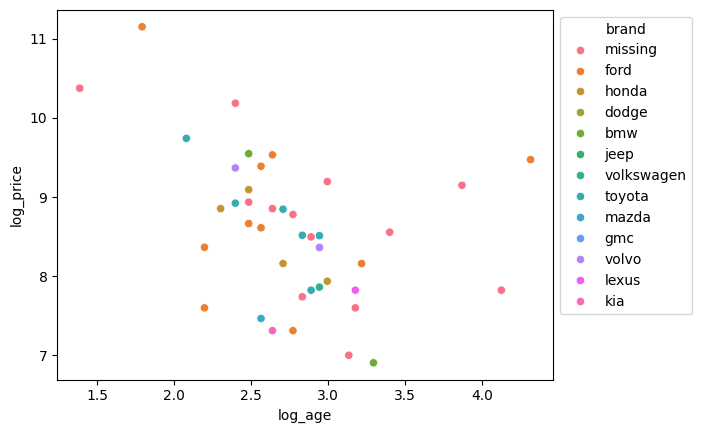

In [63]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

I'm using jewelry as my category.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/jwa?purveyor=owner#search=2~gallery~3' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [65]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [66]:
import re # Regular expressions

types = [
    'ring','necklace','bracelet','earrings','pendant',
    'chain','watch','anklet', 'box'
]
materials = [
    'gold','silver','platinum','sterling','diamond','ruby',
    'sapphire','emerald','pearl','opal'
]
re.search(r'\b(10k|14k|18k|22k|24k)\b', title)

gender = ['men','mens','women','womens','unisex']

price = int(re.sub('[^0-9]', '', price))


data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in types] # Find brands in the title
    if len(hits) == 0:
        item_type = 'missing'
    else:
        item_type = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'types':item_type})

In [67]:
import os

## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
print(df.shape)

os.makedirs('./src', exist_ok=True) # Create the 'src' directory if it doesn't exist
df.to_csv('./src/craigslist_cville_jewelry.csv') # Save data in case of a disaster
df.head()

(30, 5)


,title,price,year,link,types
0,lori griener black jewelry box mirror,30,NaN,https://charlottesville.craigslist.org/jwl/d/t...,box
1,taskets renaissance jewelry box chest of ceram...,20,NaN,https://charlottesville.craigslist.org/jwl/d/t...,box
2,raymond weil gold plated watch,150,NaN,https://charlottesville.craigslist.org/jwl/d/n...,watch
3,raymond weil 18k gold plated watch 9006,125,NaN,https://charlottesville.craigslist.org/jwl/d/n...,watch
4,watch winder for 4 watches,100,NaN,https://charlottesville.craigslist.org/jwl/d/n...,watch


count       30.000000
mean       631.333333
std       2569.904122
min          0.000000
25%         20.000000
50%         62.500000
75%        140.000000
max      13995.000000
Name: price, dtype: float64


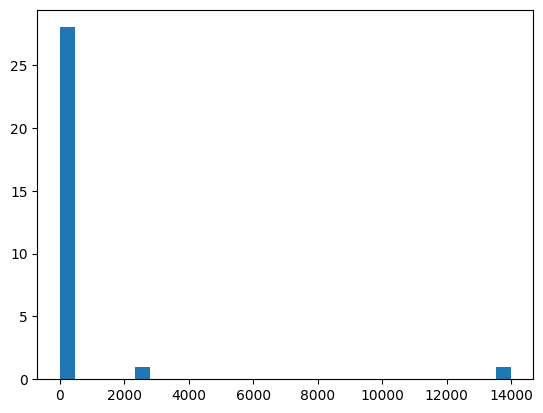

count        30
unique        7
top       watch
freq          8
Name: types, dtype: object


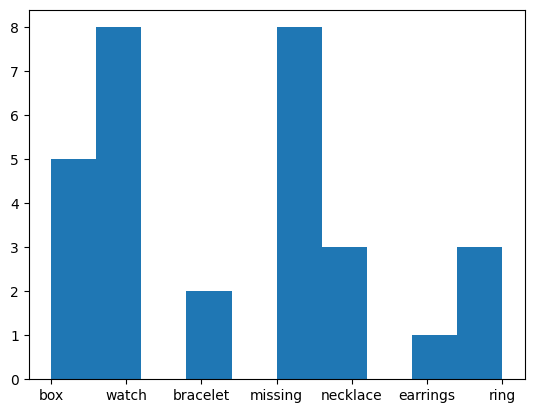

In [68]:
print(df['price'].describe())
df['price'].hist(grid=False, bins = 30)
plt.show()
print(df['types'].describe())
df['types'].hist(grid=False)
plt.show()

In [69]:
df.loc[:,['price','types']].groupby('types').describe()

price                                                               
         count         mean          std   min    25%    50%     75%      max
types                                                                        
box        5.0    45.000000    65.000000   5.0  10.00   20.0   30.00    160.0
bracelet   2.0    32.500000    24.748737  15.0  23.75   32.5   41.25     50.0
earrings   1.0    50.000000          NaN  50.0  50.00   50.0   50.00     50.0
missing    8.0  2144.250000  4876.299995   5.0  18.75   84.5  862.50  13995.0
necklace   3.0    58.666667    45.883911   6.0  43.00   80.0   85.00     90.0
ring       3.0   116.666667   160.727513   0.0  25.00   50.0  175.00    300.0
watch      8.0   115.000000    37.032804  50.0  93.75  125.0  146.25    150.0

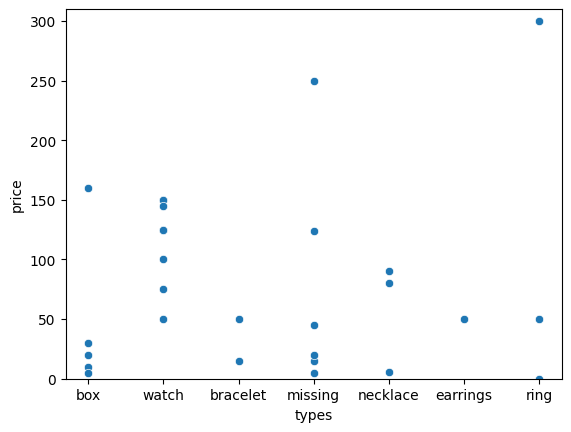

In [70]:
ax = sns.scatterplot(data=df, x='types', y='price')
ax.set_ylim(0, 310)
plt.show()

I added a Y-limit because there was an outlier at 14,000 that made the rest of the graph hard to examine. So, this cuts off data above 350, so it should not be totally accepted. However, for simple data exploration it is better for seeing which types are the most expensive on average.

           log_price
log_price        NaN
           log_price
log_price        1.0


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


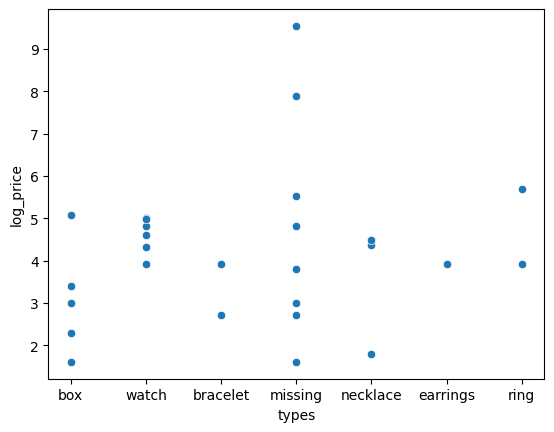

In [71]:
df['log_price'] = np.log(df['price'])

ax = sns.scatterplot(data=df, x='types', y='log_price')

# Calculate covariance and correlation only for numerical columns
print(df.loc[:,['log_price']].cov())
print(df.loc[:,['log_price']].corr())